In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils import resample

In [63]:
mult = 5

def load_file(path, flows_ok, flows_ddos):
    df_chunk = pd.read_cvs(path, chunksize=500000, low_memory=False)
    
    for data in df_chunk:
        is_benign = data[' Label'] == 'BENIGN'
        flows_ok_new = data[is_benign]
        flows_ddos_full = data[~is_benign]

        sizeDownSample = len(flows_ok_new) * mult

        if sizeDownSample < len(flows_ddos_full): 
            flows_ddos_reduced = resample(flows_ddos_full,
                                          replace=False,
                                          n_samples=sizeDownSample,
                                          random_state=27)
        else:
            flows_ddos_reduced = flows_ddos_full
        flows_ok = pd.concat([flows_ok, flows_ok_new], ignore_index=True)
        flows_ddos = pd.concat([flows_ddos, flows_ddos_reduced], ignore_index=True)
    
    return flows_ok, flows_ddos
    
flows_ok = pd.DataFrame()
flows_ddos = pd.DataFrame()
file_paths = ['cicddos2019/01-12/TFTP.csv', 'cicddos2019/01-12/DrDoS_LDAP.csv', 'cicddos2019/01-12/DrDoS_MSSQL.csv', 'cicddos2019/01-12/DrDoS_NetBIOS.csv', 
'cicddos2019/01-12/DrDoS_NTP.csv', 'cicddos2019/01-12/DrDoS_SNMP.csv', 'cicddos2019/01-12/DrDoS_SSDP.csv', 'cicddos2019/01-12/DrDoS_UDP.csv', 
'cicddos2019/01-12/Syn.csv', 'cicddos2019/01-12/DrDoS_DNS.csv', 'cicddos2019/01-12/UDPLag.csv']
for i, file_path in enumerate(file_paths, start=1):
    if i == 1:
        flows_ok, flows_ddos = load_file(file_path, flows_ok, flows_ddos)
    print(f'file {i} loaded')
samples = pd.concat([flows_ddos, flows_ok], ignore_index=True)
samples.to_csv(r'cicddos2019/01-12/export_dataframe12.csv', index=None, header=True)

print('All files loaded and processed')

file 1 loaded
file 2 loaded
file 3 loaded
file 4 loaded
file 5 loaded
file 6 loaded
file 7 loaded
file 8 loaded
file 9 loaded
file 10 loaded
file 11 loaded
All files loaded and processed


In [2]:
# training data
samples = pd.read_csv('cicddos2019/01-12/export_dataframe1.csv', sep=',')

def string2numeric_hash(text):
    import hashlib
    return int(hashlib.md5(text).hexdigest()[:8], 16)

# Flows Packet/s e Bytes/s - Replace infinity by 0
samples = samples.replace('Infinity','0')
samples = samples.replace(np.inf,0)
samples = samples.replace('nan','0')
samples[' Flow Packets/s'] = pd.to_numeric(samples[' Flow Packets/s'])
samples['Flow Bytes/s'] = samples['Flow Bytes/s'].fillna(0)
samples['Flow Bytes/s'] = pd.to_numeric(samples['Flow Bytes/s'])
samples[' Label'] = samples[' Label'].replace('BENIGN',0)
samples[' Label'] = samples[' Label'].replace('DrDoS_DNS',1)
samples[' Label'] = samples[' Label'].replace('DrDoS_LDAP',1)
samples[' Label'] = samples[' Label'].replace('DrDoS_MSSQL',1)
samples[' Label'] = samples[' Label'].replace('DrDoS_NTP',1)
samples[' Label'] = samples[' Label'].replace('DrDoS_NetBIOS',1)
samples[' Label'] = samples[' Label'].replace('DrDoS_SNMP',1)
samples[' Label'] = samples[' Label'].replace('DrDoS_SSDP',1)
samples[' Label'] = samples[' Label'].replace('DrDoS_UDP',1)
samples[' Label'] = samples[' Label'].replace('Syn',1)
samples[' Label'] = samples[' Label'].replace('TFTP',1)
samples[' Label'] = samples[' Label'].replace('UDP-lag',1)
samples[' Label'] = samples[' Label'].replace('WebDDoS',1)

#Timestamp - Drop day, then convert hour, minute and seconds to hashing 
colunaTime = samples[' Timestamp'].str.extract(r'(\d{2}:\d{2}:\d{2})\.(\d+)')
colunaTime.columns = ['horas', 'milisec']
stringHoras = pd.DataFrame(colunaTime['horas'].str.encode('utf-8'))
samples[' Timestamp'] = pd.DataFrame(stringHoras['horas'].apply(string2numeric_hash))
del colunaTime, stringHoras


# flowID - IP origem - IP destino - Simillar HTTP -> Drop (individual flow analysis)
del samples[' Source IP']
del samples[' Destination IP']
del samples['Flow ID']
del samples['SimillarHTTP']
del samples['Unnamed: 0']

samples.to_csv(r'cicddos2019/01-12/export_dataframe_proc.csv', index = None, header=True) 
print('Training data processed')

C:\Users\Chinges\AppData\Local\Temp\ipykernel_19332\1554880656.py:4: DtypeWarning: Columns (85) have mixed types. Specify dtype option on import or set low_memory=False.
  samples = pd.read_csv('cicddos2019/01-12/export_dataframe1.csv', sep=',')


Training data processed


In [2]:
from keras.models import Sequential
from keras.layers import Dense,GRU,Embedding,Dropout,Flatten,Conv1D,MaxPooling1D,LSTM
from keras.layers import GRU, LSTM, Conv1D, MaxPooling1D, Dense, Flatten, Dropout

### Convolutional Neural Network (CNN)

In [3]:
def CNN_model(input_size):
   
    # Initialize the constructor
    model = Sequential()
    
    model.add(Conv1D(filters=128, kernel_size=16, activation='sigmoid', input_shape=(input_size,1)))
    model.add(MaxPooling1D(2))
    model.add(Conv1D(filters=64, kernel_size=8, activation='sigmoid'))
    model.add(MaxPooling1D(2))
    model.add(Conv1D(filters=32, kernel_size=3, activation='sigmoid'))
    model.add(MaxPooling1D(2))
    
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    print(model.summary())
    
    return model

### Long-Short Term Memory (LSTM)

In [4]:
def LSTM_model(input_size):
    model = Sequential()
    
    model.add(LSTM(32,input_shape=(input_size,1), return_sequences=False))
    model.add(Dropout(0.5))    
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    print(model.summary())
    
    return model

### Gated Recurrent Units (GRU)

In [5]:
def GRU_model(input_size):
   
    model = Sequential()
    model.add(GRU(32, input_shape=(input_size,1), return_sequences=False)) 
    model.add(Dropout(0.5))    
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    model.build()
    print(model.summary())
    
    return model

### Split Data Train and Test

Туршилтын багцын өгөгдлийн хэмжээ, шинж чанарын тоо: (99564, 82)
Сургалтын багцын өгөгдлийн хэмжээ, шинж чанарын тоо: (232315, 82)


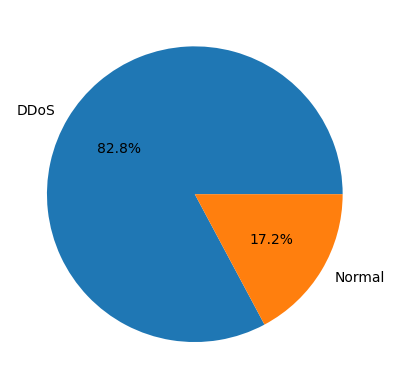

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load the data
samples = pd.read_csv('cicddos2019/01-12/export_dataframe_proc.csv', sep=',')

# Specify the data 
X = samples.iloc[:,0:(samples.shape[1]-1)]

# Specify the target labels and flatten the array
y = samples.iloc[:,-1]

# Split the data up in train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

# Concatenate the training data
X = pd.concat([X_train, y_train], axis=1)

# Filter the data based on the label
is_benign = X[' Label'] == 0 
normal = X[is_benign]
ddos = X[~is_benign]

# Print the number of testing and training samples
print('Туршилтын багцын өгөгдлийн хэмжээ, шинж чанарын тоо:', X_test.shape)
print('Сургалтын багцын өгөгдлийн хэмжээ, шинж чанарын тоо:',X_train.shape)

# Prepare data for the pie chart
labels = ['DDoS', 'Normal']
sizes = [len(ddos), len(normal)]

# Plot the pie chart
plt.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.show()


### format_{2,3}d()

##### Reshape data in 3d format (for input in methods such as GRU, CNN and LSTM)

In [7]:
def format_3d(df):
    X = np.array(df)
    return np.reshape(X, (X.shape[0], X.shape[1], 1))

### compile_train(model,X_train,y_train,deep=True)

##### Compile and train learning model


In [8]:
# compile and train learning model
def compile_train(model,X_train,y_train,deep=True):
    
    if(deep==True):
        import matplotlib.pyplot as plt

        model.compile(loss='binary_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])
        
        history = model.fit(X_train, y_train,epochs=100, batch_size=256, verbose=1)
        # summarize history for accuracy
        plt.plot(history.history['accuracy'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train'], loc='upper left')
        plt.show()
        # summarize history for loss
        plt.plot(history.history['loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train'], loc='upper left')
        plt.show()

        print(model.metrics_names)
   
    print('Model Compiled and Trained')
    return model

### testes(model,X_test,y_test,y_pred, deep=True)

#### Testing performance outcomes of the methods


In [53]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix

def testes(model,X_test,y_test,y_pred, deep=True):
    if(deep==True): 
        score = model.evaluate(X_test, y_test,verbose=1)
        print(score) 
    cm = confusion_matrix(y_test, y_pred)
    print('\nConfusion Matrix')
    print(cm)
    acc = accuracy_score(y_test, y_pred)
    print('\nAccuracy')
    print(acc)
    prec = precision_score(y_test, y_pred)
    print('\nPrecision')
    print(prec)
    rec = recall_score(y_test, y_pred)  
    print('\nRecall')
    print(rec)
    f1 = f1_score(y_test,y_pred)
    print('\nF1 Score')
    print(f1)
    
    return acc, prec, rec, f1, cm

### Main script for testing the learning methods

## Model training

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 67, 128)           2176      
                                                                 
 max_pooling1d (MaxPooling1  (None, 33, 128)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 26, 64)            65600     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 13, 64)            0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 11, 32)            6176      
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 5, 32)             0

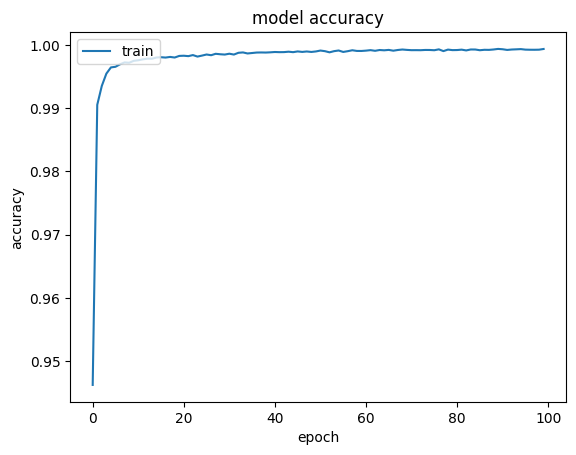

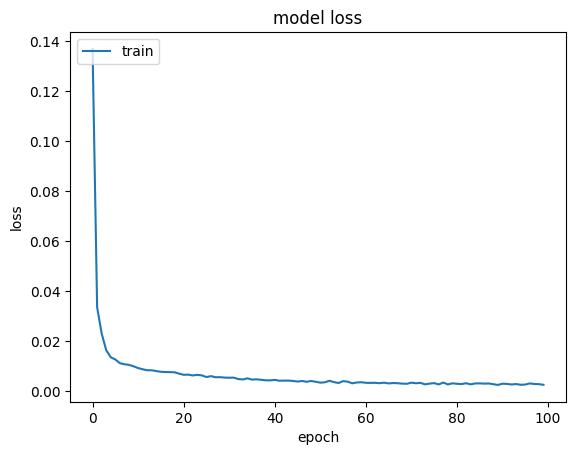

['loss', 'accuracy']
Model Compiled and Trained
Epoch 1/100
908/908 [==============================] - 36s 38ms/step - loss: 0.1281 - accuracy: 0.9530
Epoch 2/100
908/908 [==============================] - 35s 38ms/step - loss: 0.0340 - accuracy: 0.9898
Epoch 3/100
908/908 [==============================] - 35s 38ms/step - loss: 0.0242 - accuracy: 0.9934
Epoch 4/100
908/908 [==============================] - 35s 38ms/step - loss: 0.0158 - accuracy: 0.9960
Epoch 5/100
908/908 [==============================] - 35s 39ms/step - loss: 0.0142 - accuracy: 0.9964
Epoch 6/100
908/908 [==============================] - 35s 39ms/step - loss: 0.0126 - accuracy: 0.9970
Epoch 7/100
908/908 [==============================] - 35s 39ms/step - loss: 0.0139 - accuracy: 0.9964
Epoch 8/100
908/908 [==============================] - 35s 39ms/step - loss: 0.0118 - accuracy: 0.9972
Epoch 9/100
908/908 [==============================] - 35s 39ms/step - loss: 0.0104 - accuracy: 0.9975
Epoch 10/100
908/908 [===

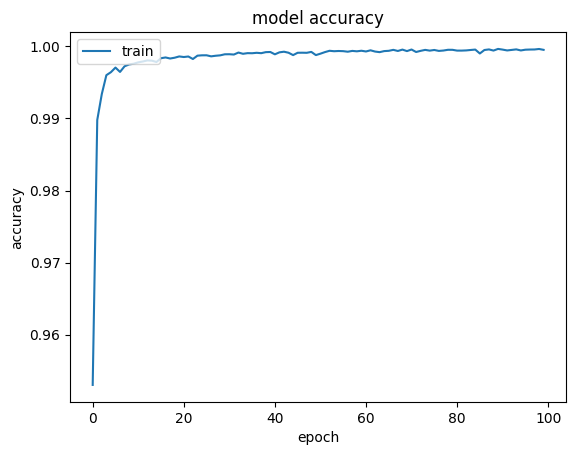

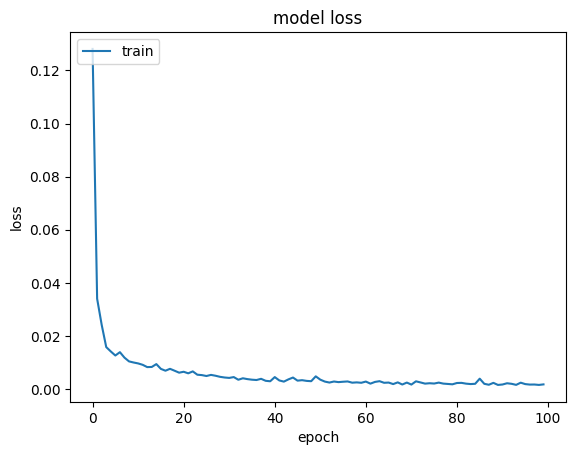

['loss', 'accuracy']
Model Compiled and Trained
Epoch 1/100
908/908 [==============================] - 31s 33ms/step - loss: 0.1256 - accuracy: 0.9544
Epoch 2/100
908/908 [==============================] - 30s 33ms/step - loss: 0.0309 - accuracy: 0.9902
Epoch 3/100
908/908 [==============================] - 30s 33ms/step - loss: 0.0197 - accuracy: 0.9950
Epoch 4/100
908/908 [==============================] - 30s 33ms/step - loss: 0.0180 - accuracy: 0.9961
Epoch 5/100
908/908 [==============================] - 30s 33ms/step - loss: 0.0152 - accuracy: 0.9970
Epoch 6/100
908/908 [==============================] - 30s 33ms/step - loss: 0.0192 - accuracy: 0.9955
Epoch 7/100
908/908 [==============================] - 30s 33ms/step - loss: 0.0153 - accuracy: 0.9968
Epoch 8/100
908/908 [==============================] - 30s 33ms/step - loss: 0.0137 - accuracy: 0.9970
Epoch 9/100
908/908 [==============================] - 30s 33ms/step - loss: 0.0139 - accuracy: 0.9971
Epoch 10/100
908/908 [===

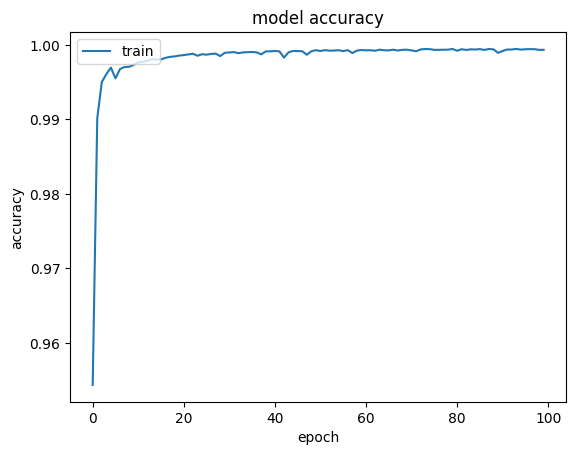

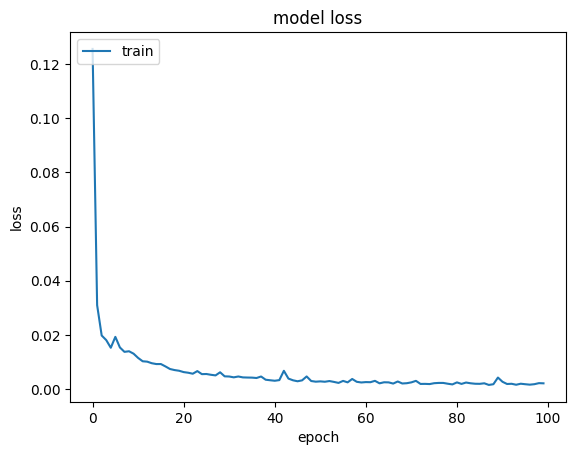

['loss', 'accuracy']
Model Compiled and Trained


In [11]:
model_cnn = CNN_model(82)
model_lstm = LSTM_model(82)
model_gru = GRU_model(82) 

model_cnn = compile_train(model_cnn,format_3d(X_train),y_train) 
model_lstm = compile_train(model_lstm,format_3d(X_train),y_train)
model_gru = compile_train(model_gru,format_3d(X_train),y_train)

In [57]:
resultt = pd.DataFrame(columns=['Method','Accuracy','Precision','Recall', 'F1_Score','Confusion Matrix'])

### CNN

In [58]:
y_pred = model_cnn.predict(format_3d(X_test)) 
y_pred = y_pred.round()
acc, prec, rec, f1, cm   = testes(model_cnn,format_3d(X_test),y_test,y_pred)
new_row = pd.DataFrame({'Method': ['CNN'], 'Accuracy': [acc], 'Precision': [prec], 'Recall': [rec], 'F1_Score': [f1],'Confusion Matrix': [cm]})
resultt = pd.concat([resultt, new_row], ignore_index=True)

3112/3112 [==============================] - 8s 3ms/step - loss: 0.0027 - accuracy: 0.9992
[0.002683293307200074, 0.9992467164993286]

Confusion Matrix
[[16888    44]
 [   31 82601]]

Accuracy
0.9992467156803664

Precision
0.9994676023957892

Recall
0.9996248426759609

F1 Score
0.9995462163519424


C:\Users\Chinges\AppData\Local\Temp\ipykernel_45332\984280558.py:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  resultt = pd.concat([resultt, new_row], ignore_index=True)


### LSTM

In [59]:
y_pred = model_lstm.predict(format_3d(X_test)) 
y_pred = y_pred.round()
acc, prec, rec, f1, cm  = testes(model_lstm,format_3d(X_test),y_test,y_pred)
new_row = pd.DataFrame({'Method': ['LSTM'], 'Accuracy': [acc], 'Precision': [prec], 'Recall': [rec], 'F1_Score': [f1],'Confusion Matrix': [cm]})
resultt = pd.concat([resultt, new_row], ignore_index=True)

3112/3112 [==============================] - 16s 5ms/step - loss: 0.0029 - accuracy: 0.9994
[0.002879659179598093, 0.9993773102760315]

Confusion Matrix
[[16897    35]
 [   27 82605]]

Accuracy
0.9993772849624363

Precision
0.9995764762826719

Recall
0.9996732500726111

F1 Score
0.9996248608354713


### GRU

In [60]:
y_pred = model_gru.predict(format_3d(X_test)) 
y_pred = y_pred.round()
acc, prec, rec, f1,  testes(model_gru,format_3d(X_test),y_test,y_pred)
new_row = pd.DataFrame({'Method': ['GRU'], 'Accuracy': [acc], 'Precision': [prec], 'Recall': [rec], 'F1_Score': [f1],'Confusion Matrix': [cm]})
resultt = pd.concat([resultt, new_row], ignore_index=True)

3112/3112 [==============================] - 12s 4ms/step - loss: 0.0025 - accuracy: 0.9993
[0.002499501220881939, 0.9993170499801636]

Confusion Matrix
[[16909    23]
 [   45 82587]]

Accuracy
0.9993170222168656

Precision
0.9997215833434209

Recall
0.9994554167876851

F1 Score
0.999588482347103


### Results

In [61]:
resultt

,Method,Accuracy,Precision,Recall,F1_Score,Confusion Matrix
0,CNN,0.999247,0.999468,0.999625,0.999546,"[[16888, 44], [31, 82601]]"
1,LSTM,0.999377,0.999576,0.999673,0.999625,"[[16897, 35], [27, 82605]]"
2,GRU,0.999377,0.999576,0.999673,0.999625,"[[16897, 35], [27, 82605]]"


Confusion Matrix for CNN:
[[16888    44]
 [   31 82601]]


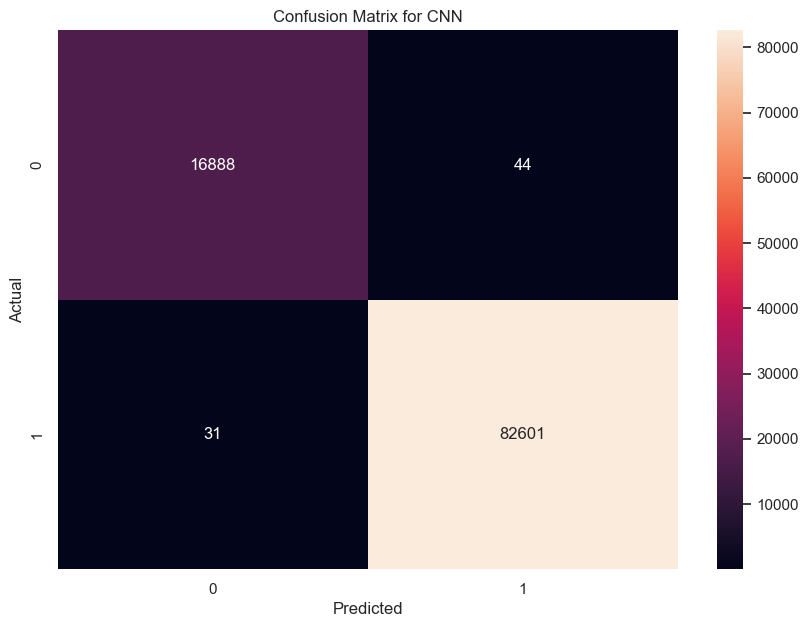

Confusion Matrix for LSTM:
[[16897    35]
 [   27 82605]]


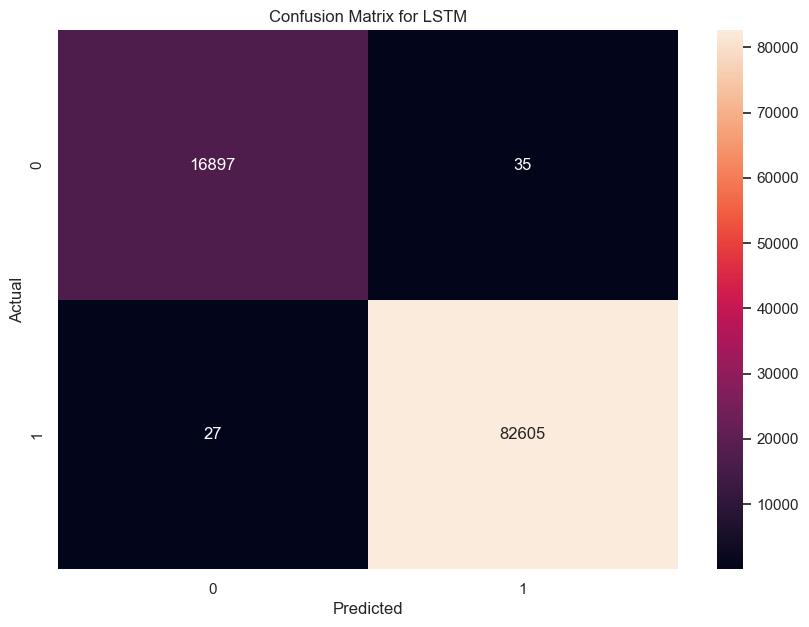

Confusion Matrix for GRU:
[[16897    35]
 [   27 82605]]


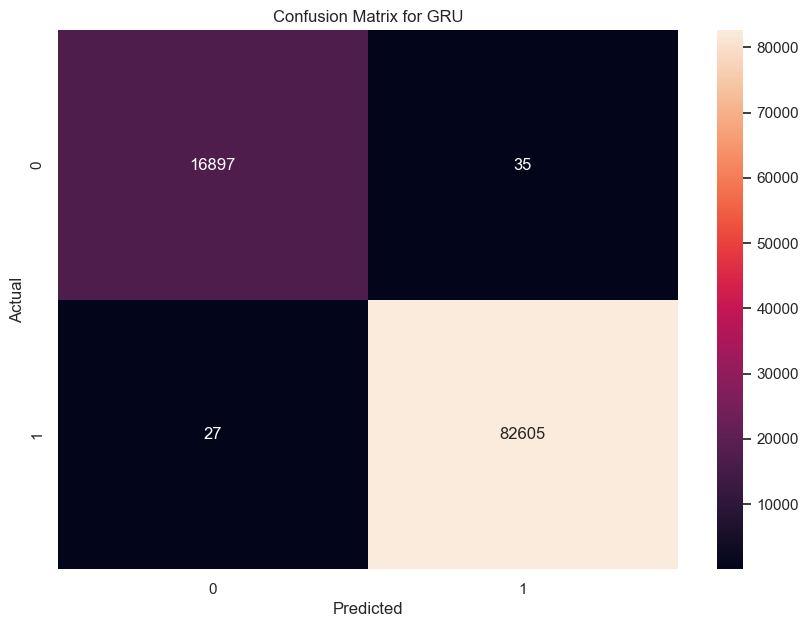

In [62]:
import seaborn as sns
import matplotlib.pyplot as plt
for index, row in result.iterrows():
    cm = row['Confusion Matrix']  # Get the confusion matrix
    method = row['Method']  # Get the method name

    print(f'Confusion Matrix for {method}:')
    print(cm)

    plt.figure(figsize=(10,7))  # Create a new figure
    sns.heatmap(cm, annot=True, fmt='d')  # Create a heatmap from the confusion matrix
    plt.title(f'Confusion Matrix for {method}')  # Set the title of the plot
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()  # Display the plot


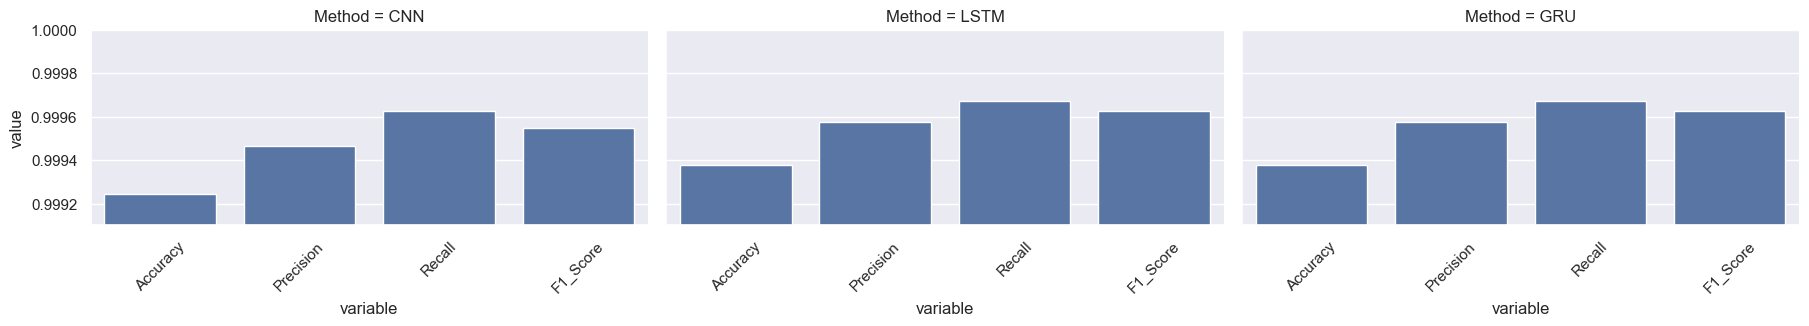

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
# Reshape the DataFrame to long-form
melted_results = pd.melt(resultt.iloc[:,:5], id_vars='Method')

# Create the catplot with the reshaped DataFrame
ax = sns.catplot(data=melted_results, col='Method', col_wrap=3, x='variable', y='value', kind='bar', height=3, aspect=2)
ax.set(ylim=(0.9991, 1))
ax.set_xticklabels(rotation=45)

C:\Users\Chinges\AppData\Local\Temp\ipykernel_45332\437757593.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
C:\Users\Chinges\AppData\Local\Temp\ipykernel_45332\437757593.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
C:\Users\Chinges\AppData\Local\Temp\ipykernel_45332\437757593.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


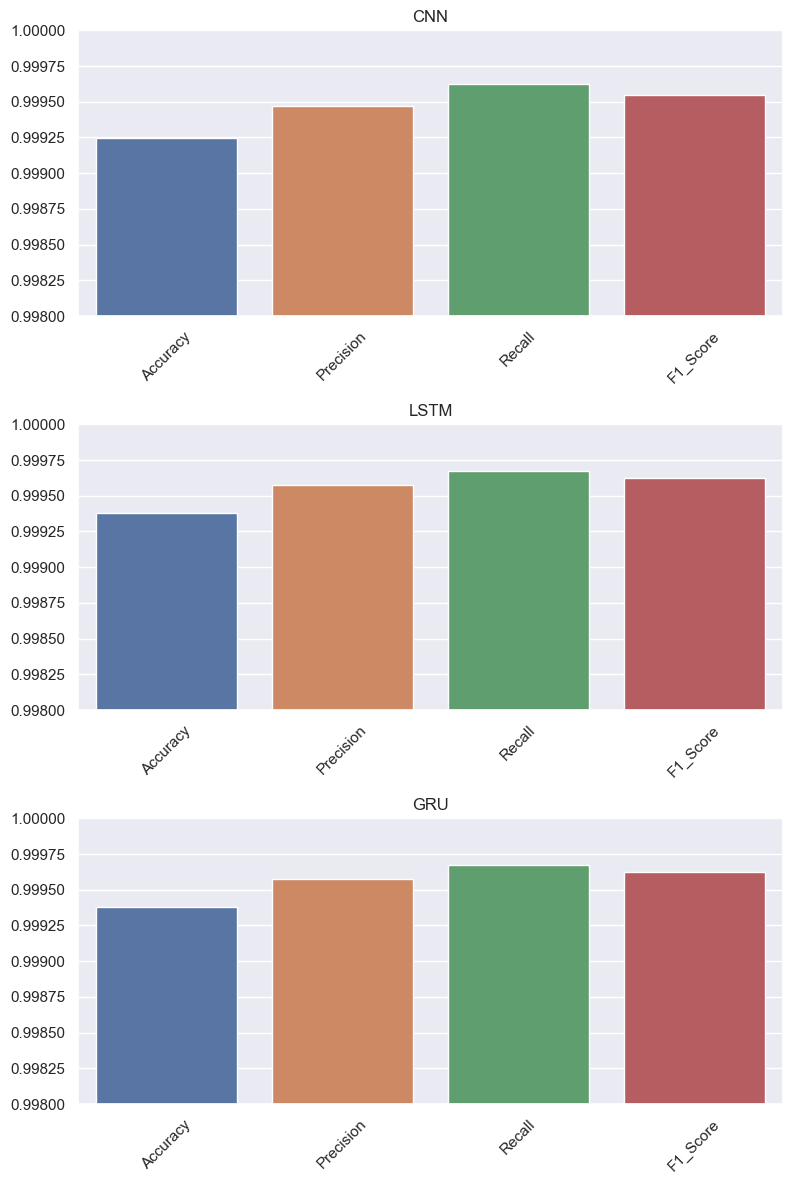

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt

methods = resultt['Method'].unique()

fig, axes = plt.subplots(nrows=len(methods), ncols=1, figsize=(8, 4 * len(methods)))

for i, method in enumerate(methods):
    method_data = resultt.loc[resultt['Method'] == method].iloc[:,:5]
    ax = sns.barplot(data=method_data, ax=axes[i])
    ax.set_ylim(0.998, 1)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    ax.set_title(method)

plt.tight_layout()
plt.show()